## Plan of work <a id = "plan"> </a>

[1. Downloading data](#1.)<br>
[2. EDA](#2.)<br>

In [2]:
import re
import os
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk

from IPython.core.display import display, HTML
from nltk.corpus import stopwords
from collections import defaultdict
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

nltk.download("stopwords")

C:\Users\chern\AppData\Local\Temp\ipykernel_7084\347378086.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chern\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. Downloading data <a id = "1."> </a>

[Back to plan](#plan)

The organizers of the competition provided 2 datasets: train and test, one of which, respectively, has true markup and the other does not. <br>
The task belongs to a binary classification task as we only have 2 classes. A positive class indicates that the question is not sincere. <br>

In [3]:
PATH = "./Data"

train = pd.read_csv(os.path.join(PATH, "train.csv"))
print(train.shape)
train.head()

(1306122, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
test = pd.read_csv(os.path.join(PATH, "test.csv"))
print(test.shape)
test.head()

(375806, 2)


,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


# 2. EDA <a id = "2."> </a>

[Back to plan](#plan)

The train dataset contains 1306122 questions, and the test dataset contains 375806 questions.

## Target Distributions

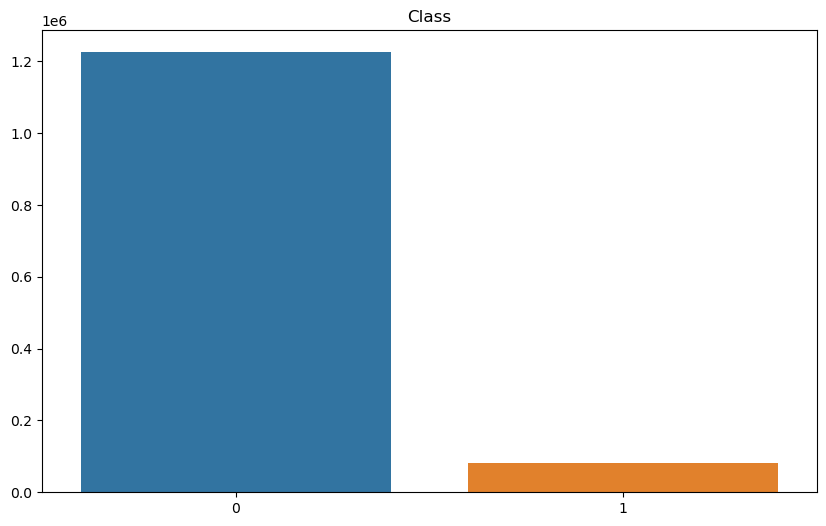

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

sns.countplot(x="target", data=train, ax=axes, zorder=2)
axes.set_title("Class")
axes.set(xlabel=None, ylabel=None)
plt.show()

### (As a percentage)

In [9]:
print(train.target.value_counts(normalize=True))

0    0.93813
1    0.06187
Name: target, dtype: float64


In [7]:
print(train.target.value_counts())

0    1225312
1      80810
Name: target, dtype: int64


There is a large class imbalance in the training data, 94% of class 0 objects and 6% of class 1 objects. <br>
For us, this means that it is more important to correctly identify class 1 objects and evaluate our results taking into account the class imbalance. <br>
Our model will be useless if it accurately classifies class 0 objects and performs poorly on class 1 objects. <br>

## Number words

In [13]:
import nltk
from nltk.corpus import stopwords as nltk_stopwords
import re
import string

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

def heavy_text_clean(x):
    # first we lowercase everything
    x = x.lower()
    x = ' '.join([word for word in x.split(' ') if word not in stopwords])
    # remove unicode characters
    x = x.encode('ascii', 'ignore').decode()
    x = re.sub(r'https*\S+', ' ', x)
    x = re.sub(r'http*\S+', ' ', x)
    # then use regex to remove @ symbols and hashtags
    x = re.sub(r'@\S', '', x)
    x = re.sub(r'#\S+', ' ', x)
    x = re.sub(r'\'\w+', '', x)
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    x = re.sub(r'\s[^\w\s]\s', '', x)
    # remove single letters and numbers surrounded by space
    x = re.sub(r'\s[a-z]\s|\s[0-9]\s', ' ', x)
    return x

train["question_text_prep"] = train["question_text"].apply(heavy_text_clean)
test["question_text_prep"] = test["question_text"].apply(heavy_text_clean)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chern\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
print("Number words in train dataset: ", len(
    " ".join(train["question_text_prep"].tolist()).split()))
print("Number words in test dataset: ", len(
    " ".join(test["question_text_prep"].tolist()).split()))

Number words in train dataset:  8508433
Number words in test dataset:  2449841


## Vocabulary size

In [ ]:
vocab_size = len(set(" ".join(train["question_text_prep"].tolist()).split(
) + " ".join(test["question_text_prep"].tolist()).split()))
print("Vocabulary size: ", vocab_size)

In [15]:
vocab_size = len(set(" ".join(train["question_text_prep"].tolist()).split(
) + " ".join(test["question_text_prep"].tolist()).split()))
print("Vocabulary size: ", vocab_size)

Vocabulary size:  204261


## Movie Description Example

In [8]:
def print_texts(df):
    inner_html = ""
    for idx, row in df.iterrows():
        inner_html += f"""
        <td style="vertical-align:top; border-right: 1px solid #7accd8">
        <h3 style="text-align:left">{row.qid}</h3>
        <hr>
            <dl>
                <dt> Genre </dt>
                <dd>{row.target}</dd>
            </dl>
            
            <hr>
            <p>
            {row.question_text}
            </p>
        </td>
        """
    display(HTML(f"""
    <table style="font-family: monospace;">
        <tr>
             {inner_html}
        </tr>
    </table>
    """))


In [9]:
class_0 = train[train.target == 0].head(3)
print_texts(class_0)

00002165364db923c7e6 Genre 0 How did Quebec nationalists see their province as a nation in the 1960s?,"000032939017120e6e44 Genre 0 Do you have an adopted dog, how would you encourage people to adopt and not shop?",0000412ca6e4628ce2cf Genre 0 Why does velocity affect time? Does velocity affect space geometry?


In [10]:
class_1 = train[train.target == 1].head(3)
print_texts(class_1)

0000e91571b60c2fb487 Genre 1 Has the United States become the largest dictatorship in the world?,00013ceca3f624b09f42 Genre 1 Which babies are more sweeter to their parents? Dark skin babies or light skin babies?,0004a7fcb2bf73076489 Genre 1 If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?


## Text Analysis

### Number of Characters

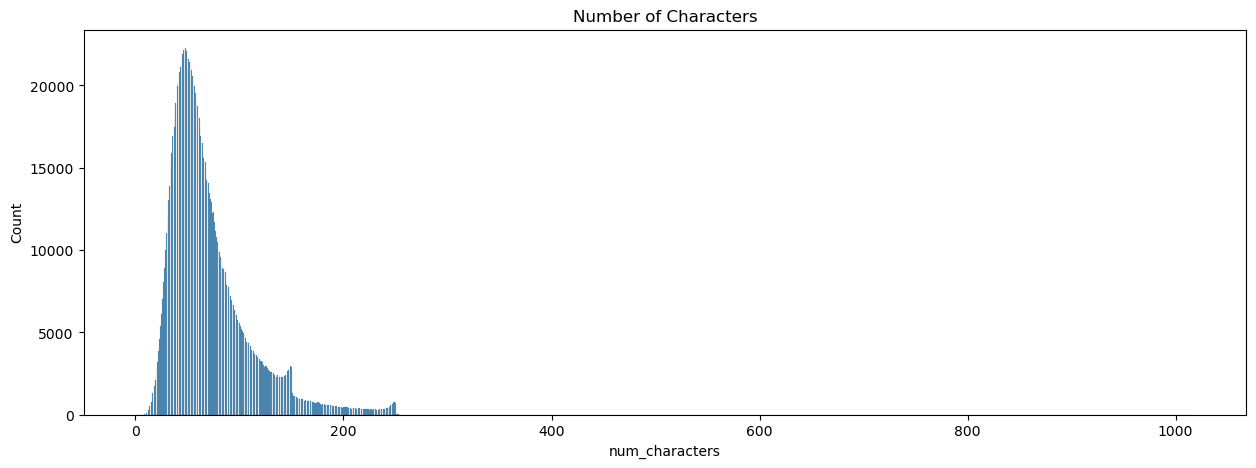

In [11]:
fig = plt.figure(figsize=(15, 5))
train["num_characters"] = train["question_text"].str.len()

sns.histplot(data=train, x="num_characters")
plt.title("Number of Characters")
plt.show()

### Number of Words

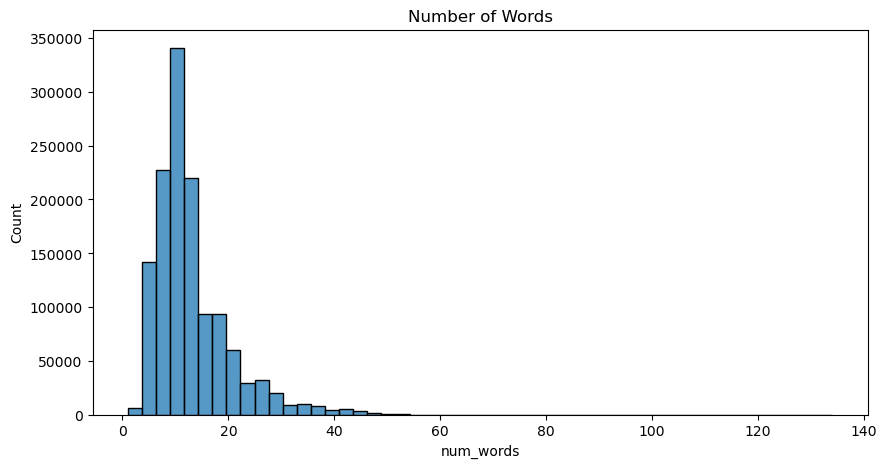

In [24]:
fig = plt.figure(figsize=(10, 5))
train["num_words"] = train["question_text"].apply(
    lambda x: len(str(x).split()))
sns.histplot(data=train, x="num_words", bins=50)
plt.title("Number of Words")
plt.show()

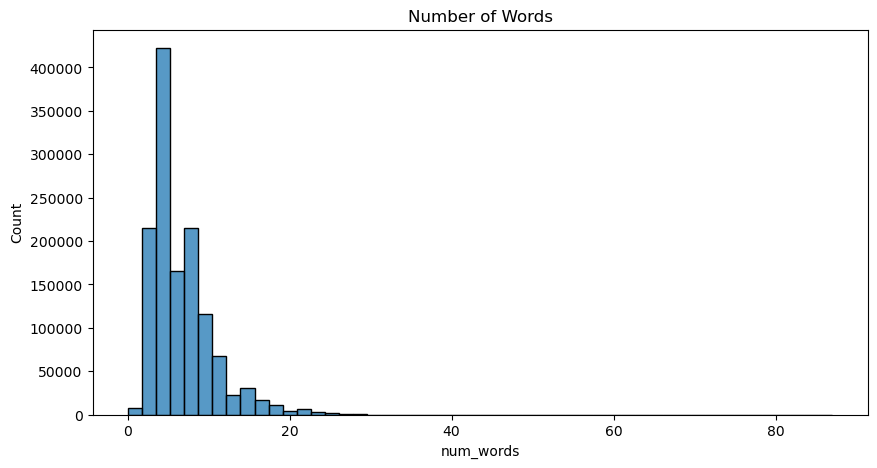

In [23]:
fig = plt.figure(figsize=(10, 5))
train["num_words"] = train["question_text_prep"].apply(
    lambda x: len(str(x).split()))
sns.histplot(data=train, x="num_words", bins=50)
plt.title("Number of Words")
plt.show()

This is how the distribution of the number of words (excluding stop-words and symbols) in questions looks like. <br>
As you can see from the graph, people mostly use no more than 20 words in their questions, but there are also long questions reaching up to 80 words or more.

In [13]:
train["num_words"].describe()

count    1.306122e+06
mean     1.280361e+01
std      7.052437e+00
min      1.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.500000e+01
max      1.340000e+02
Name: num_words, dtype: float64

### Common Stopwords

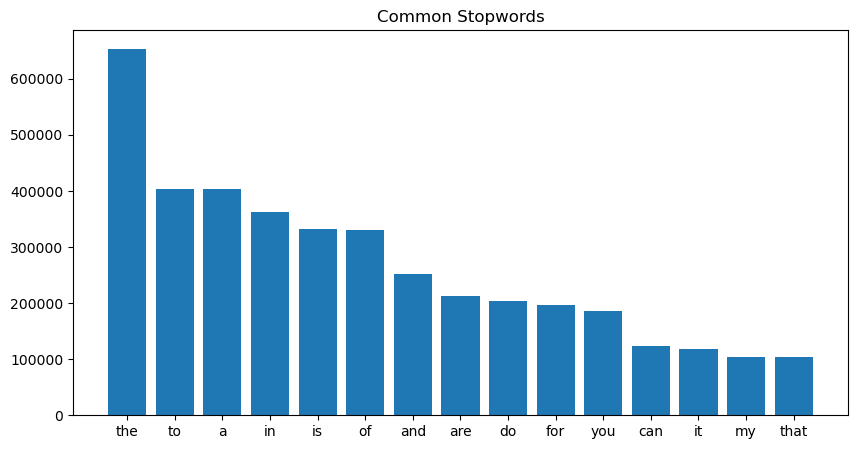

In [20]:
fig = plt.figure(figsize=(10, 5))

stop_words = set(stopwords)
corpus = "".join(map(str, train.question_text)).split()

dic = defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word] += 1
top_words = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
x, y = zip(*top_words)
plt.bar(x, y)
plt.title("Common Stopwords")
plt.show()

### Word Cloud

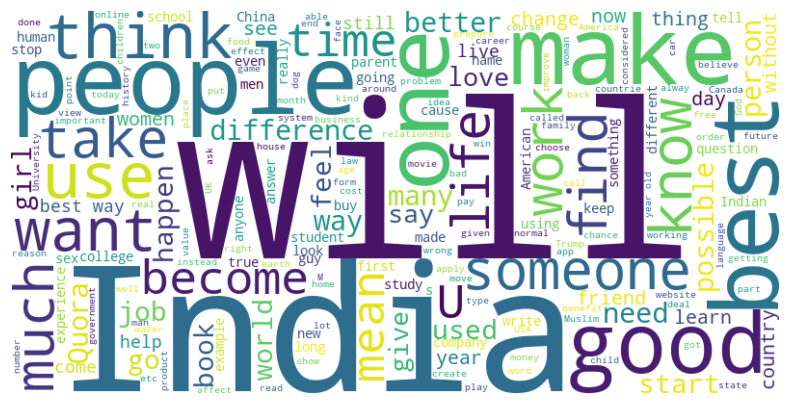

In [16]:
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(
    "".join(map(str, train.question_text)))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

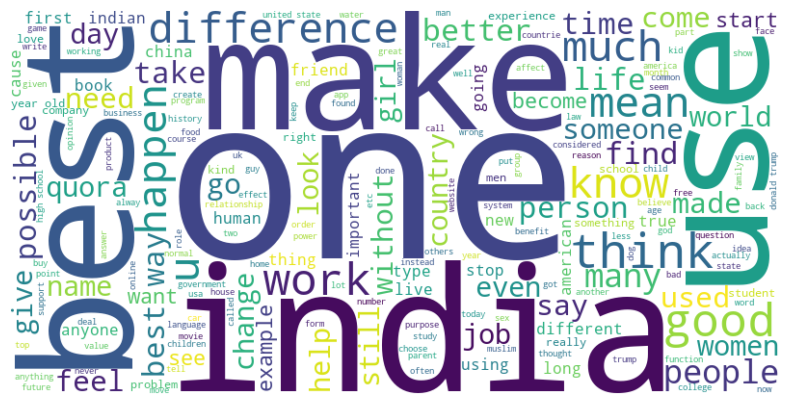

In [25]:
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(
    "".join(map(str, train.question_text_prep)))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The graph shows the most important words for the train dataset. As we see among them such words as India, one, make, best, use. <br>
Indirectly, we can assume that there are a lot of questions in the training dataset about India and how to make or use something in the best way. <br>